Задача 1. Оцінювання дефолту клієнта за допомогою скорингової моделі на основі дерев рішень 
1. Для набору навчальних даних з файлу Data_Base_I.xls розбити вхідну вибірку на навчальну та тестову (для перевірки якості моделі використати не менше 10% вхідної вибірки).
2. Застосувати щонайменше 2 різних алгоритми побудови дерев рішень, побудувати дерева рішень та визначити ймовірність події – дефолту клієнта.
3. Виконати перевірку якості моделей за допомогою тестової вибірки.
4. Обчислити загальну похибку моделей (CA – common accuracy) та похибки класифікації –1-го, 2-го роду на навчальній та тестовій вибірці.
5. Побудувати скорингові моделі у вигляді дерева рішень, використовуючи різні значення порогу. При класифікації розгляньте випадки 95%, 90%, 85 та 80%.
6. Занести результати моделювання з різними порогами та різними алгоритмами побудови у порівняльну таблицю.
7. Оформити протокол у вигляді порівняння обох методів, структур дерев та зробити висновки.


In [176]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [177]:
df = pd.read_csv('DataBase.csv')

df.head()

,Gender,Age,Сredit_sum,Currency,Term_of_crediting_in day,Interest rate_%,Duration_of_stay_in_a_sity,Maritial_status,Children,Job_position,Tenure_with_current_employer,Term_of_existence_of_enterprise,Company_type,Number_of_employees_in_kompany,Income_customer,Costs_customer,goal_credit,Result
0,Female,27,850,UAH,360,18,24_60,SINGLE,c0,PE,24_60,24_60,FS,100_9999,674,362,consumer_credit,good
1,Male,35,400,USD,240,12,24_60,SINGLE,c0,AS,24_60,24_60,FMG,51_100,690,342,consumer_credit,bad
2,Male,43,2750,UAH,240,14,24_60,MARRIED,c1,AS,12_18,12_24,OT,31_50,1588,767,consumer_credit,good
3,Male,43,15000,USD,1800,15,60_120,MARRIED,c1,TM,24_60,24_60,OT,0_5,4869,800,consumer_credit,bad
4,Male,28,2500,UAH,1080,18,60_120,SINGLE,c0,PE,0_3,0_12,FS,100_9999,637,382,consumer_credit,good


In [178]:
df.isnull().sum().sum()

0

There are no missing values in this dataset

In [179]:
df.apply(lambda x: x.unique())

Gender                                                                [Female, Male]
Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Сredit_sum                         [850, 400, 2750, 15000, 2500, 2215, 54600, 200...
Currency                                              [UAH, USD, EUR, 0,  USD,  UAH]
Term_of_crediting_in day           [360, 240, 1800, 1080, 90, 2520, 60, 720, 1080...
Interest rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_sity          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12

In [180]:
df.columns = df.columns.str.strip()

df.rename(columns={'Term_of_crediting_in day': 'Term_of_crediting_in_days',
                   'Interest rate_%': 'Interest_rate_%',
                   'Duration_of_stay_in_a_sity': 'Duration_of_stay_in_a_city',
                   'Number_of_employees_in_kompany': 'Number_of_employees_in_company',
                   'goal_credit': 'Goal_credit'}, inplace=True)


In [181]:
df.apply(lambda x: x.unique())

Gender                                                                [Female, Male]
Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Сredit_sum                         [850, 400, 2750, 15000, 2500, 2215, 54600, 200...
Currency                                              [UAH, USD, EUR, 0,  USD,  UAH]
Term_of_crediting_in_days          [360, 240, 1800, 1080, 90, 2520, 60, 720, 1080...
Interest_rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_city          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12

### Gender

In [182]:
df['Gender'].value_counts()

Gender
Male      8136
Female    6864
Name: count, dtype: int64

In [183]:
df = pd.get_dummies(df, columns=['Gender'])

In [184]:
df[['Gender_Female', 'Gender_Male']].head()

,Gender_Female,Gender_Male
0,True,False
1,False,True
2,False,True
3,False,True
4,False,True


### Age

<Axes: title={'center': 'Age Distribution'}, ylabel='Frequency'>

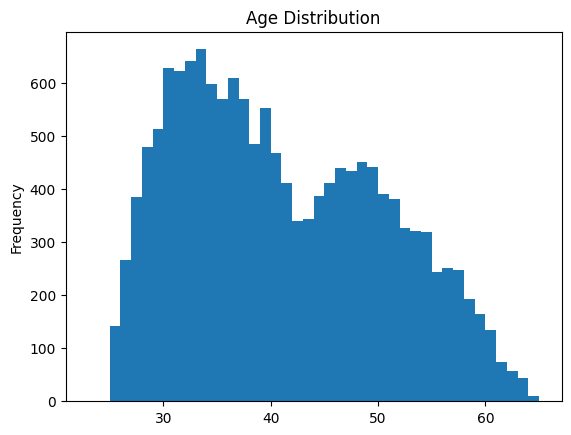

In [185]:
num_bins = len(df['Age'].unique())
df['Age'].plot(kind='hist', bins=num_bins, title='Age Distribution')

In [186]:
df['Age'].describe()

count   15,000.00
mean        40.59
std          9.46
min         23.00
25%         33.00
50%         39.00
75%         48.00
max         65.00
Name: Age, dtype: float64

### Credit Sum

<Axes: title={'center': 'Credit Sum Distibution'}, ylabel='Frequency'>

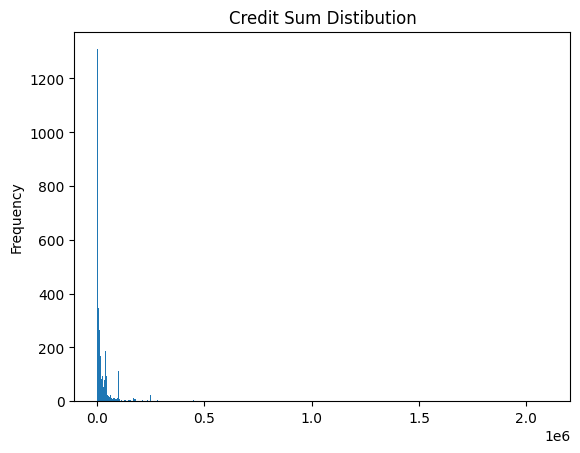

In [187]:
num_bins = len(df['Сredit_sum'].unique())
df['Сredit_sum'].plot(kind='hist', bins=num_bins, title='Credit Sum Distibution')

### Currency

In [188]:
df['Currency'] = df['Currency'].str.strip()
df['Currency'].replace('0', np.nan, inplace=True)

/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_97942/379763580.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Currency'].replace('0', np.nan, inplace=True)


In [189]:
print(df['Currency'].unique())
df.loc[df['Currency'].isnull()]

['UAH' 'USD' 'EUR' nan]


,Age,Сredit_sum,Currency,Term_of_crediting_in_days,Interest_rate_%,Duration_of_stay_in_a_city,Maritial_status,Children,Job_position,Tenure_with_current_employer,Term_of_existence_of_enterprise,Company_type,Number_of_employees_in_company,Income_customer,Costs_customer,Goal_credit,Result,Gender_Female,Gender_Male
5251,44,2619,NaN,360,28,120_9999,MARRIED,c2,AS,120_9999,120_9999,OT,100_9999,1138,155,consumer_credit,good,True,False
14249,40,96000,NaN,5400,13,6_12,MARRIED,c1,AS,24_60,24_60,WB,0_5,8397,0,flat,good,True,False


In [190]:
df.dropna(subset=['Currency'], inplace=True)
df['Currency'].unique()

array(['UAH', 'USD', 'EUR'], dtype=object)

Lets add the column named location

In [191]:
df['Location'] = df['Currency'].map({'USD': 'USA', 'UAH': 'UA', 'EUR': 'EU'})

df[['Currency', 'Location']].head()

,Currency,Location
0,UAH,UA
1,USD,USA
2,UAH,UA
3,USD,USA
4,UAH,UA


Convert everything to hryvnas, so we wont confuse the model

In [192]:
exchange_rates = {
    'UAH': 1,   
    'USD': 41,  
    'EUR': 46   
}

df['Credit_sum_in_UAH'] = df['Сredit_sum'] * df['Currency'].map(exchange_rates)
df['Income_in_UAH'] = df['Income_customer'] * df['Currency'].map(exchange_rates)
df['Costs_in_UAH'] = df['Costs_customer'] * df['Currency'].map(exchange_rates)

df[['Сredit_sum', 'Income_customer', 'Costs_customer', 'Currency', 'Credit_sum_in_UAH', 'Income_in_UAH', 'Costs_in_UAH']].head()

,Сredit_sum,Income_customer,Costs_customer,Currency,Credit_sum_in_UAH,Income_in_UAH,Costs_in_UAH
0,850,674,362,UAH,850,674,362
1,400,690,342,USD,16400,28290,14022
2,2750,1588,767,UAH,2750,1588,767
3,15000,4869,800,USD,615000,199629,32800
4,2500,637,382,UAH,2500,637,382


In [193]:
df.drop(columns=['Сredit_sum', 'Income_customer', 'Costs_customer', 'Currency'], inplace=True)

### Term of crediting in day
as the interest rate is in year percentage, I think it would be better to convert days in years 

In [194]:
df['Term_of_crediting_in_days'].min(), df['Term_of_crediting_in_days'].max()

(30, 109685055)

There are some outliers, so I will drop all of the rows where credit is given for more then 30 years

In [195]:
df = df[df['Term_of_crediting_in_days'] <= 10980]

df[['Term_of_crediting_in_days']].describe()

,Term_of_crediting_in_days
count,"14,986.00"
mean,"2,015.65"
std,"1,627.77"
min,30.00
25%,720.00
50%,"1,800.00"
75%,"2,520.00"
max,"10,800.00"


In [196]:
df['Term_of_crediting_in_years'] = df['Term_of_crediting_in_days']/365
df.drop(columns=['Term_of_crediting_in_days'], inplace=True)

df[['Term_of_crediting_in_years']].head()

,Term_of_crediting_in_years
0,0.99
1,0.66
2,0.66
3,4.93
4,2.96


In [197]:
df['Term_of_crediting_in_years'].min(), df['Term_of_crediting_in_years'].max()

(0.0821917808219178, 29.589041095890412)

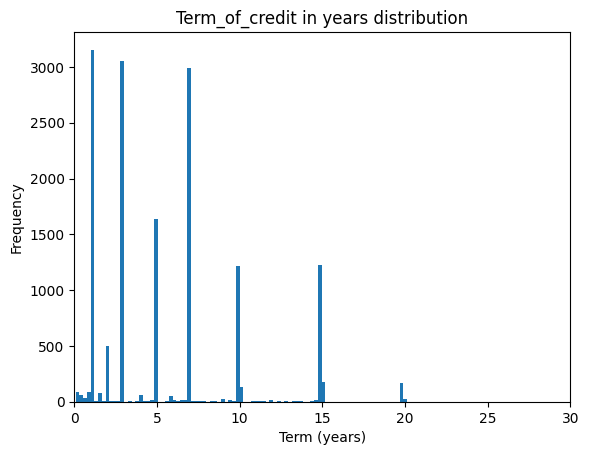

In [198]:
num_bins = len(df['Term_of_crediting_in_years'].unique())
plt.hist(df['Term_of_crediting_in_years'], bins=num_bins)

plt.xlim(0, 30)

plt.title('Term_of_credit in years distribution')
plt.xlabel('Term (years)')
plt.ylabel('Frequency')
plt.show()

In [199]:
df['Total_repayment'] = df['Credit_sum_in_UAH'] * (1 + (df['Interest_rate_%'] / 100) * df['Term_of_crediting_in_years'])
pd.options.display.float_format = '{:,.2f}'.format
df[['Credit_sum_in_UAH', 'Interest_rate_%', 'Term_of_crediting_in_years', 'Total_repayment']].head()

,Credit_sum_in_UAH,Interest_rate_%,Term_of_crediting_in_years,Total_repayment
0,850,18,0.99,"1,000.90"
1,16400,12,0.66,"17,694.03"
2,2750,14,0.66,"3,003.15"
3,615000,15,4.93,"1,069,931.51"
4,2500,18,2.96,"3,831.51"


In [200]:
bins = [0, 1, 5, 30]
labels = ['Short-Term', 'Medium-Term', 'Long-Term']  
df['Loan_Term_Category'] = pd.cut(df['Term_of_crediting_in_years'], bins=bins, labels=labels, right=False)
df[['Term_of_crediting_in_years', 'Loan_Term_Category']].head()


,Term_of_crediting_in_years,Loan_Term_Category
0,0.99,Short-Term
1,0.66,Short-Term
2,0.66,Short-Term
3,4.93,Medium-Term
4,2.96,Medium-Term


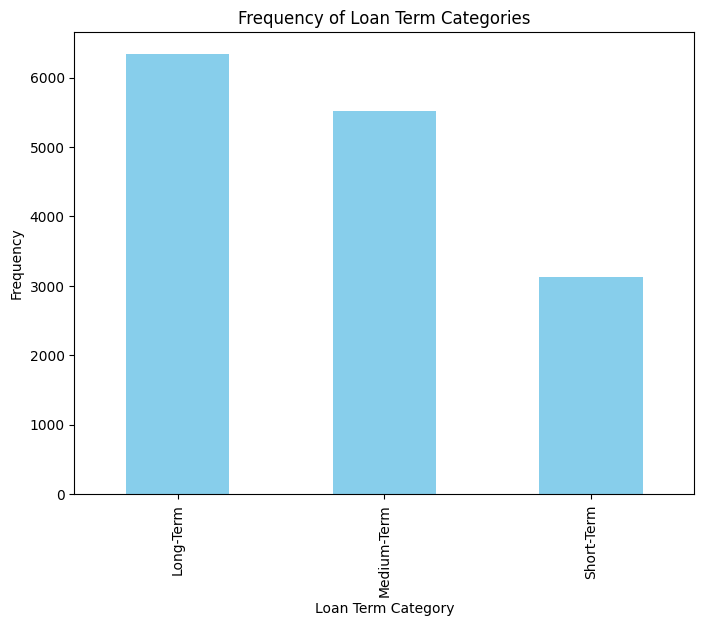

In [201]:
category_counts = df['Loan_Term_Category'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')

plt.title('Frequency of Loan Term Categories')
plt.xlabel('Loan Term Category')
plt.ylabel('Frequency')
plt.show()

In [202]:
df['Interest_rate_%'].min(), df['Interest_rate_%'].max()

(0, 30)

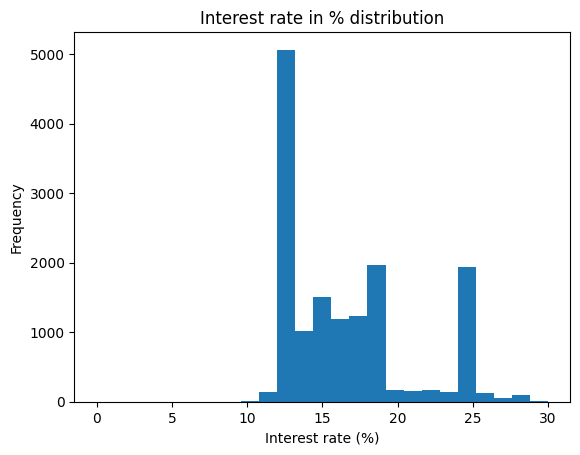

In [203]:
num_bins = len(df['Interest_rate_%'].unique())

df['Interest_rate_%'].plot(kind='hist', bins=num_bins, title='Interest rate in % distribution')
plt.xlabel('Interest rate (%)')
plt.ylabel('Frequency')
plt.show()

In [204]:
df = pd.get_dummies(df, columns=['Maritial_status', 'Job_position'], drop_first=True)
df = pd.get_dummies(df, columns=['Location'])

In [205]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Number_of_employees_in_company'] = le.fit_transform(df['Number_of_employees_in_company'])

In [206]:
df['Children'] = df['Children'].replace({'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3})

/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_97942/2645860986.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Children'] = df['Children'].replace({'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3})


In [207]:
print(df['Duration_of_stay_in_a_city'].unique())
print(df['Tenure_with_current_employer'].unique())
print(df['Term_of_existence_of_enterprise'].unique())
print(df['Company_type'].unique())
print(df['Goal_credit'].unique())

['24_60' '60_120' '120_9999' '12_24' '6_12' '3_6' '0_3']
['24_60' '12_18' '0_3' '60_120' '120_9999' '3_6' '18_24' '6_12']
['24_60' '12_24' '0_12' '120_9999' '60_120']
['FS' 'FMG' 'OT' 'WB' 'EC' 'HI' 'MPP' 'ASTL' 'EOG' 'ITT' 'FMCG' 'AP' 'RE'
 'MFC' 'ALC' 'PSL' 'CA' 'LI' 'AG' 'TSPW' 'ESB' 'CI' 'HRC']
['consumer_credit' 'flat' 'house' 'overhaul' 'auto' 'consumer_credit ']


Choosing middle value instead of range, so column is a number

In [208]:
duration_mapping = {'24_60': 42, '60_120': 90, '120_9999': 1000, '12_24': 18, 
                    '6_12': 9, '3_6': 4.5, '0_3': 1.5}
df['Duration_of_stay_in_a_city'] = df['Duration_of_stay_in_a_city'].replace(duration_mapping)

tenure_mapping = {'24_60': 42, '12_18': 15, '0_3': 1.5, '60_120': 90, '120_9999': 1000, 
                  '3_6': 4.5, '18_24': 21, '6_12': 9}
df['Tenure_with_current_employer'] = df['Tenure_with_current_employer'].replace(tenure_mapping)

existence_mapping = {'24_60': 42, '12_24': 18, '0_12': 6, '120_9999': 1000, '60_120': 90}
df['Term_of_existence_of_enterprise'] = df['Term_of_existence_of_enterprise'].replace(existence_mapping)

df[['Duration_of_stay_in_a_city', 'Tenure_with_current_employer', 'Term_of_existence_of_enterprise']].head()


/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_97942/4055239683.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Duration_of_stay_in_a_city'] = df['Duration_of_stay_in_a_city'].replace(duration_mapping)
/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_97942/4055239683.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Tenure_with_current_employer'] = df['Tenure_with_current_employer'].replace(tenure_mapping)
/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_97942/4055239683.py:10: FutureW

,Duration_of_stay_in_a_city,Tenure_with_current_employer,Term_of_existence_of_enterprise
0,42.00,42.00,42
1,42.00,42.00,42
2,42.00,15.00,18
3,90.00,42.00,42
4,90.00,1.50,6


In [209]:
df['Goal_credit'] = df['Goal_credit'].str.strip()
df = pd.get_dummies(df, columns=['Company_type', 'Goal_credit'])

df.head()

,Age,Interest_rate_%,Duration_of_stay_in_a_city,Children,Tenure_with_current_employer,Term_of_existence_of_enterprise,Number_of_employees_in_company,Result,Gender_Female,Gender_Male,...,Company_type_OT,Company_type_PSL,Company_type_RE,Company_type_TSPW,Company_type_WB,Goal_credit_auto,Goal_credit_consumer_credit,Goal_credit_flat,Goal_credit_house,Goal_credit_overhaul
0,27,18,42.00,0,42.00,42,1,good,True,False,...,False,False,False,False,False,False,True,False,False,False
1,35,12,42.00,0,42.00,42,3,bad,False,True,...,False,False,False,False,False,False,True,False,False,False
2,43,14,42.00,1,15.00,18,2,good,False,True,...,True,False,False,False,False,False,True,False,False,False
3,43,15,90.00,1,42.00,42,0,bad,False,True,...,True,False,False,False,False,False,True,False,False,False
4,28,18,90.00,0,1.50,6,1,good,False,True,...,False,False,False,False,False,False,True,False,False,False


In [210]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['Loan_Term_Category'] = label_encoder.fit_transform(df['Loan_Term_Category'])

df['Loan_Term_Category'].unique()

array([2, 1, 0])

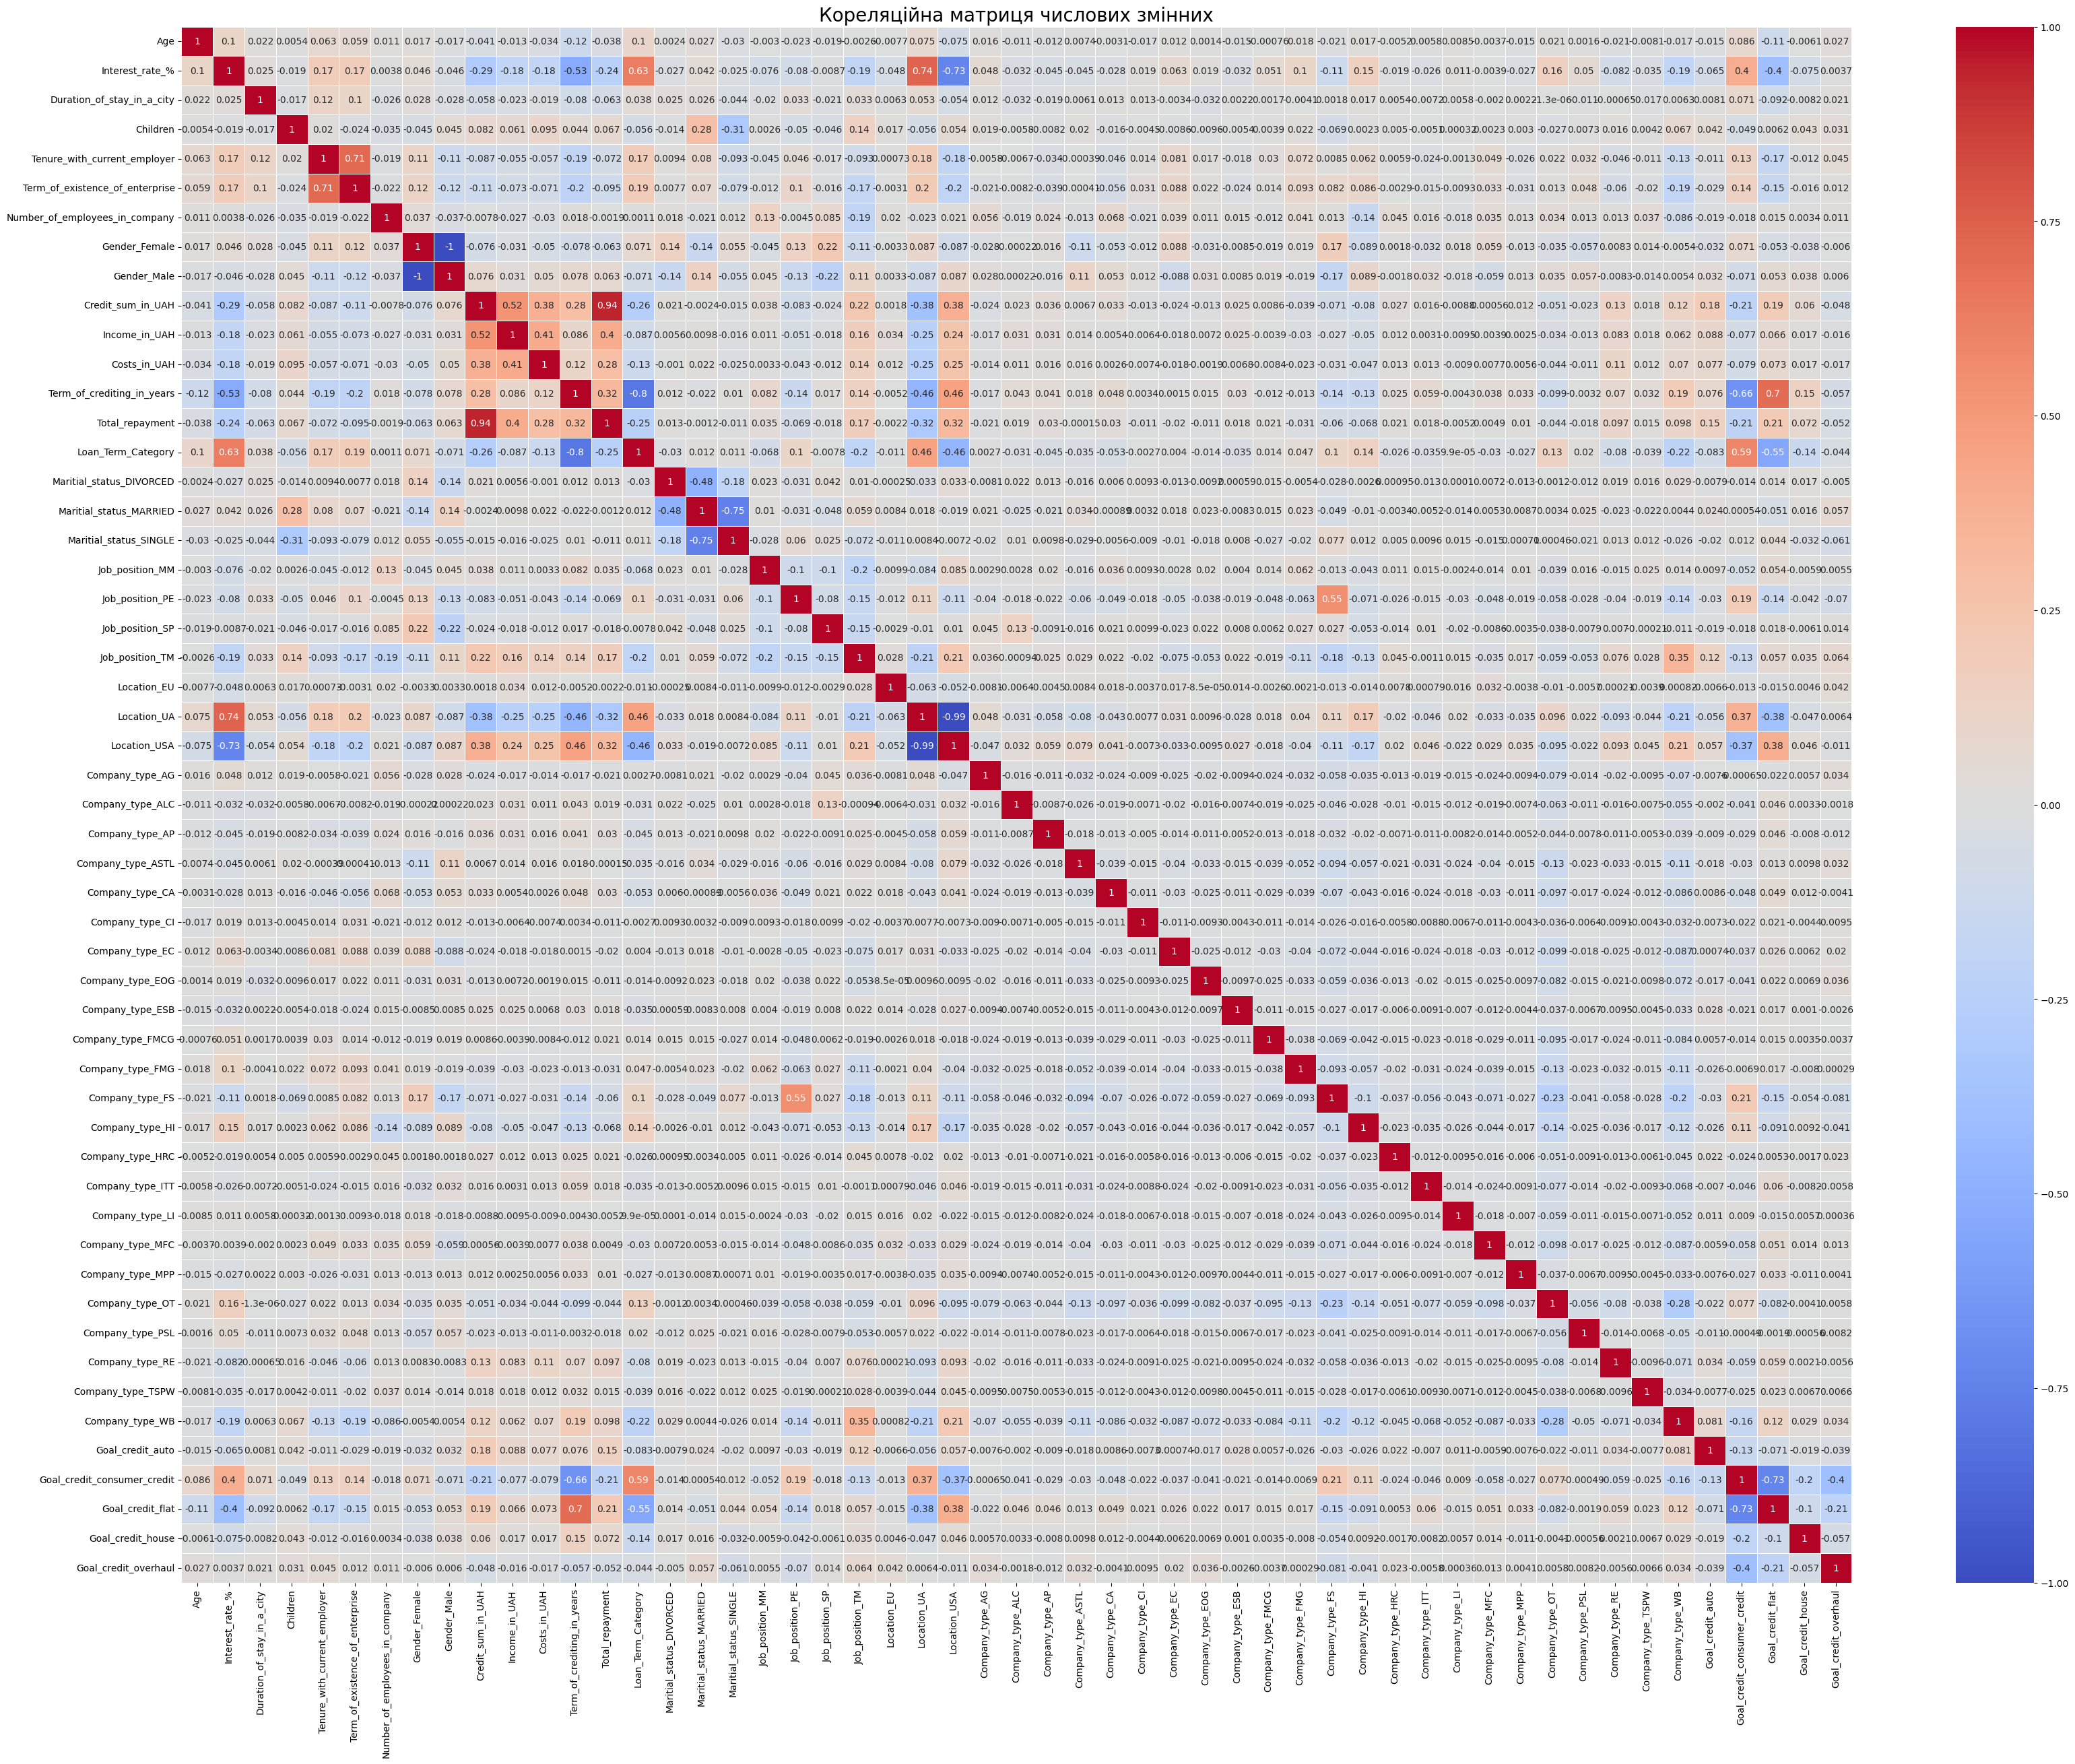

In [211]:
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'bool'])  
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(40, 30)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Кореляційна матриця числових змінних', fontsize=20)
plt.show()


In [212]:
columns_to_drop = ['Credit_sum_in_UAH', 'Job_position_MM', 'Job_position_TM', 'Job_position_SP', 
                   'Company_type_ITT', 'Company_type_MPP']

df.drop(columns=columns_to_drop, inplace=True)

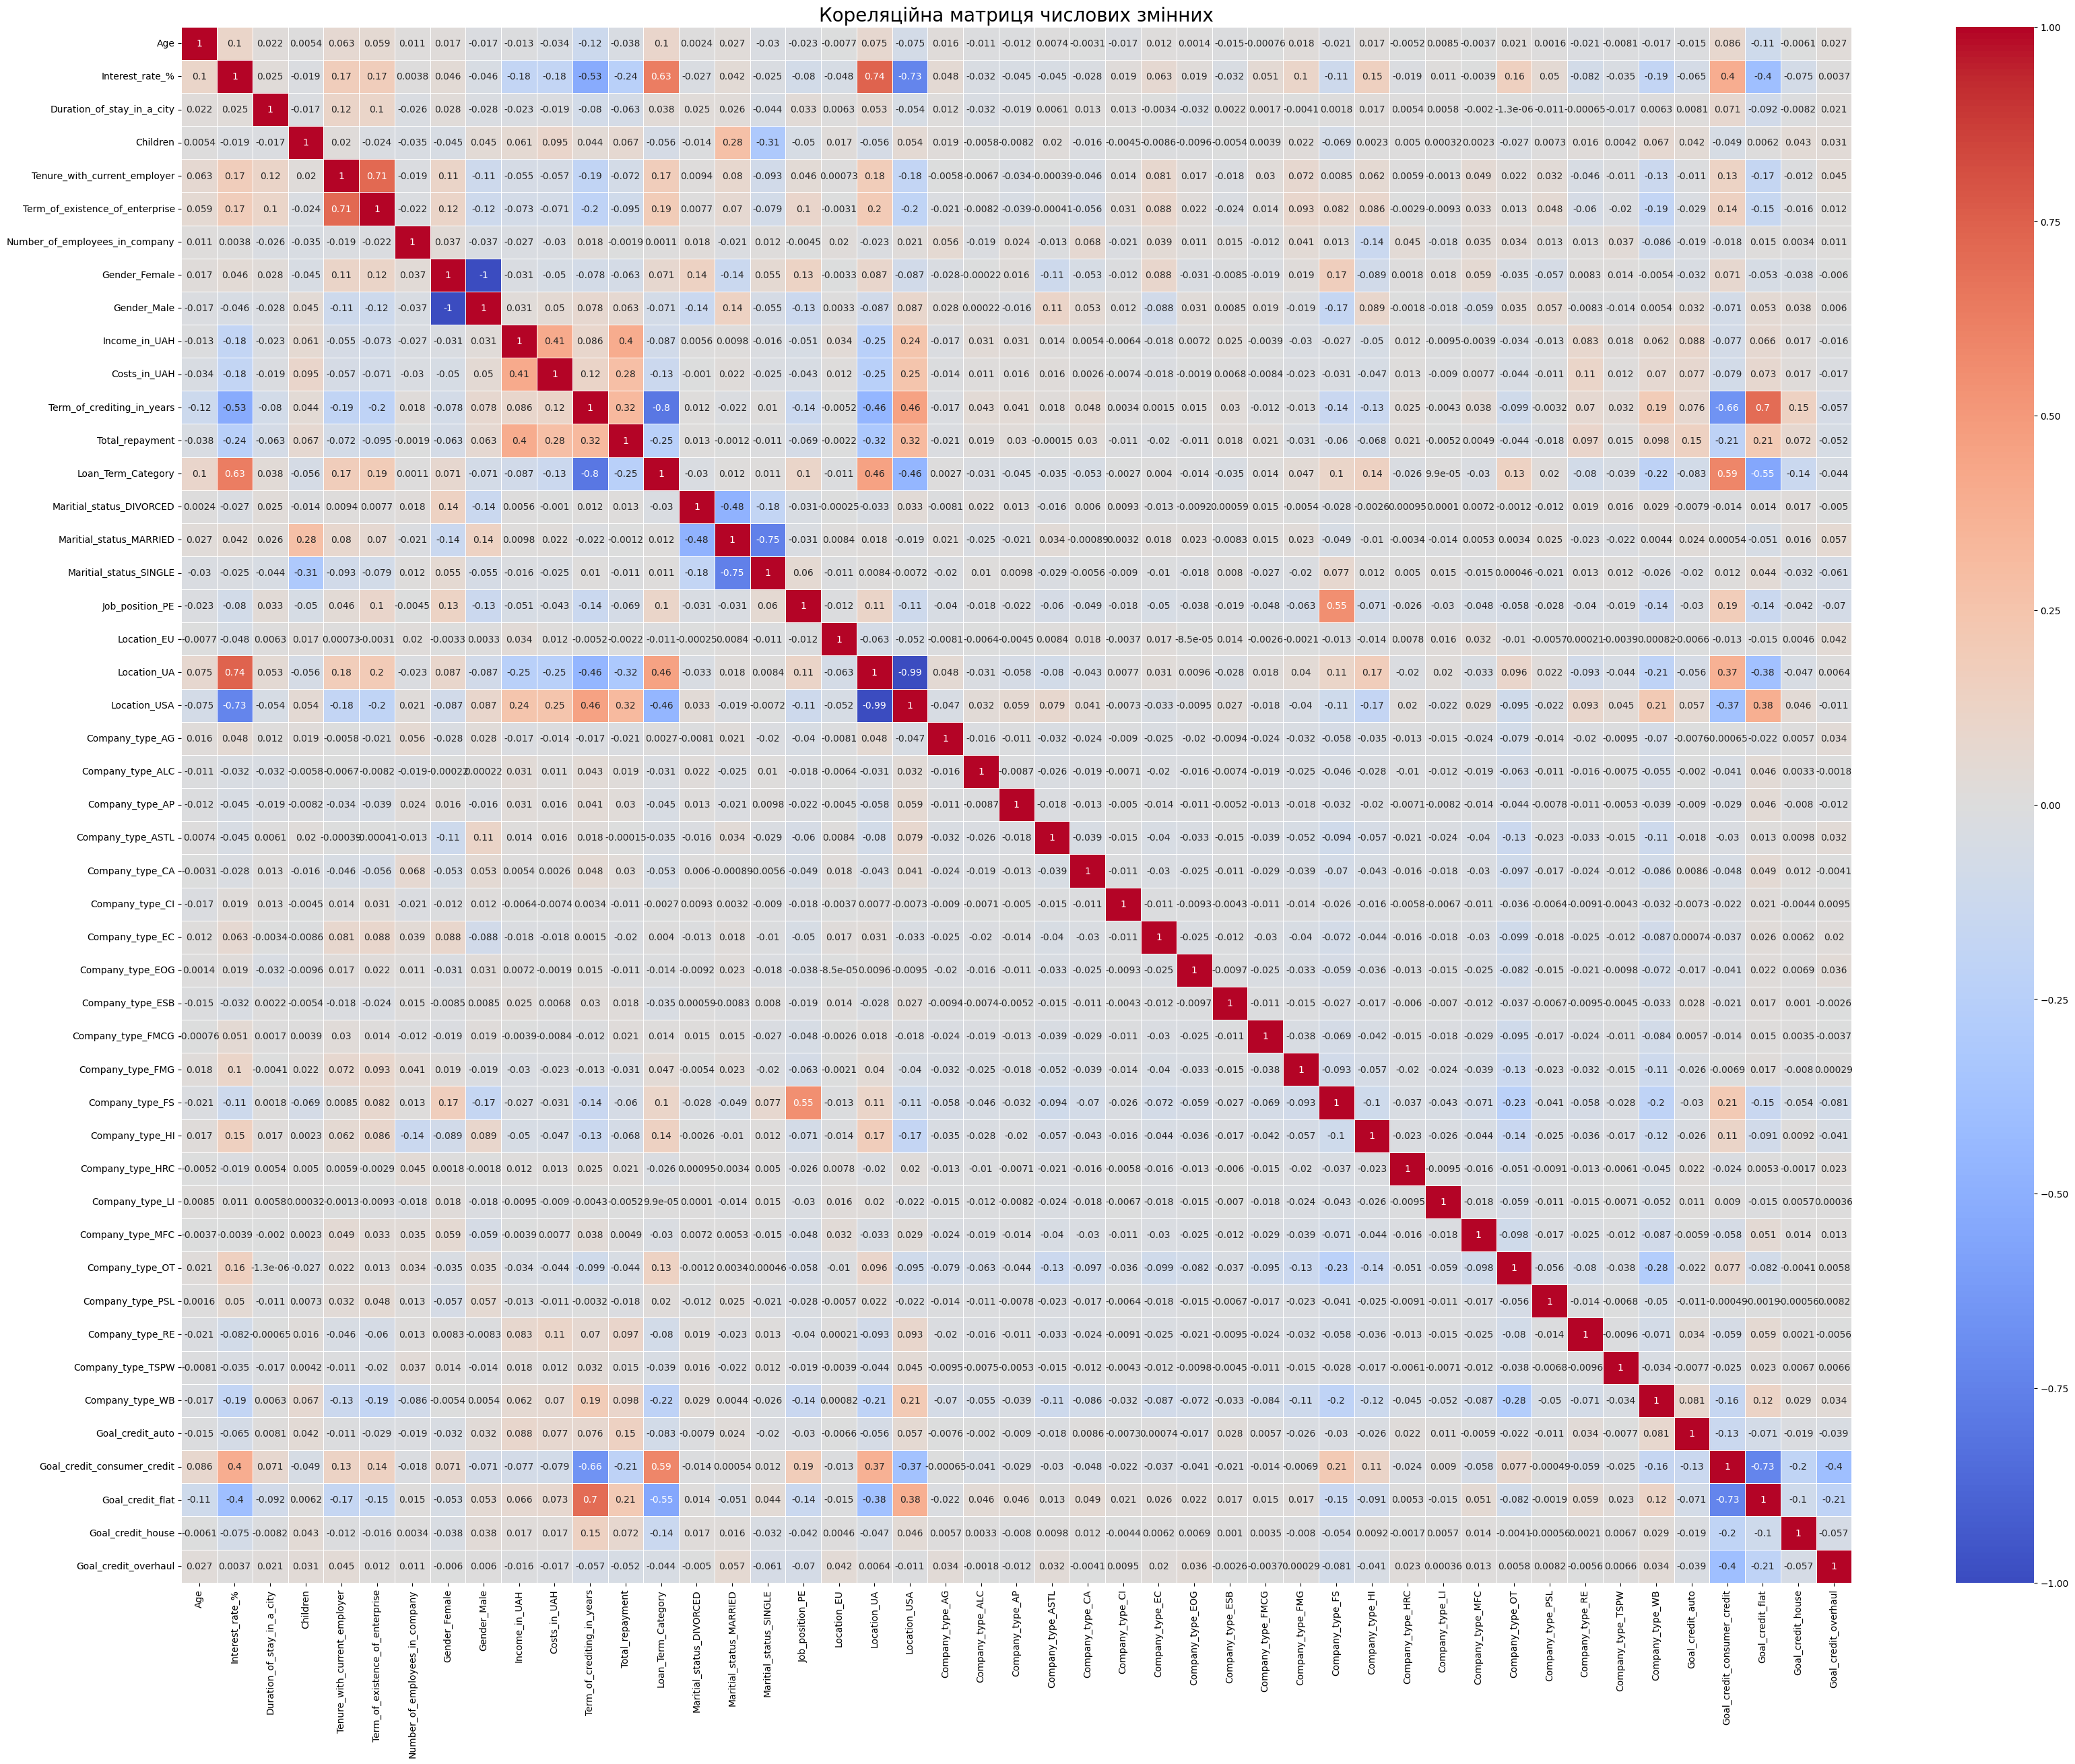

In [213]:
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'bool'])  # Вибираємо числові колонки
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Кореляційна матриця числових змінних', fontsize=20)
plt.show()

In [214]:
df.apply(lambda x: x.unique())

Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Interest_rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_city                 [42.0, 90.0, 1000.0, 18.0, 9.0, 4.5, 1.5]
Children                                                                [0, 1, 2, 3]
Tenure_with_current_employer         [42.0, 15.0, 1.5, 90.0, 1000.0, 4.5, 21.0, 9.0]
Term_of_existence_of_enterprise                                [42, 18, 6, 1000, 90]
Number_of_employees_in_company                                       [1, 3, 2, 0, 4]
Result                                                                   [good, bad]
Gender_Female                                                          [True, False]
Gender_Male                                                            [False, True]
Income_in_UAH                      [674, 28290, 1588, 199629, 637, 745, 3648, 393...
Costs_in_UAH                       [362, 14022, 767, 32800, 382, 

In [215]:
# Перевірка унікальних значень у стовпці 'Result' перед мапінгом
print("Унікальні значення в стовпці 'Result' перед мапінгом:")
print(df['Result'].unique())

# Перевірка кількості пропущених значень у стовпці 'Result'
print("Кількість пропущених значень у стовпці 'Result':", df['Result'].isnull().sum())

# Перевірка наявності пустих значень або незрозумілих даних у стовпці 'Result'
print("Частковий перегляд рядків із пропущеними або підозрілими значеннями у стовпці 'Result':")
print(df[df['Result'].isnull()])  # Це покаже всі рядки, де 'Result' є NaN


Унікальні значення в стовпці 'Result' перед мапінгом:
['good' 'bad']
Кількість пропущених значень у стовпці 'Result': 0
Частковий перегляд рядків із пропущеними або підозрілими значеннями у стовпці 'Result':
Empty DataFrame
Columns: [Age, Interest_rate_%, Duration_of_stay_in_a_city, Children, Tenure_with_current_employer, Term_of_existence_of_enterprise, Number_of_employees_in_company, Result, Gender_Female, Gender_Male, Income_in_UAH, Costs_in_UAH, Term_of_crediting_in_years, Total_repayment, Loan_Term_Category, Maritial_status_DIVORCED, Maritial_status_MARRIED, Maritial_status_SINGLE, Job_position_PE, Location_EU, Location_UA, Location_USA, Company_type_AG, Company_type_ALC, Company_type_AP, Company_type_ASTL, Company_type_CA, Company_type_CI, Company_type_EC, Company_type_EOG, Company_type_ESB, Company_type_FMCG, Company_type_FMG, Company_type_FS, Company_type_HI, Company_type_HRC, Company_type_LI, Company_type_MFC, Company_type_OT, Company_type_PSL, Company_type_RE, Company_type_TS

In [216]:
df['Result'] = df['Result'].map({'good': 1, 'bad': 0})

In [217]:
# Крок 1: Розділення даних на ознаки та цільову змінну
X = df.drop('Result', axis=1)
y = df['Result']

In [218]:
# Крок 2: Розділення на тренувальний та тестовий набори
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [219]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC Score: {roc_auc:.4f}")
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [220]:
def predict_with_thresholds(model, X_test, y_test, thresholds=[0.95, 0.90, 0.85, 0.80]):
    probas = model.predict_proba(X_test)[:, 1]
    
    metrics_data = []

    for threshold in thresholds:
        y_pred_threshold = np.where(probas >= threshold, 1, 0)
        
        accuracy = accuracy_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)
        recall = recall_score(y_test, y_pred_threshold)
        f1 = f1_score(y_test, y_pred_threshold)
        
        conf_matrix = confusion_matrix(y_test, y_pred_threshold)
        true_positives = conf_matrix[1, 1]
        true_negatives = conf_matrix[0, 0]
        false_positives = conf_matrix[0, 1]
        false_negatives = conf_matrix[1, 0]
        
        metrics_data.append({
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'True Positives': true_positives,
            'True Negatives': true_negatives,
            'False Positives': false_positives,
            'False Negatives': false_negatives
        })

    metrics_df = pd.DataFrame(metrics_data)
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], marker='o', label='Accuracy')
    plt.plot(metrics_df['Threshold'], metrics_df['Precision'], marker='o', label='Precision')
    plt.plot(metrics_df['Threshold'], metrics_df['Recall'], marker='o', label='Recall')
    plt.plot(metrics_df['Threshold'], metrics_df['F1 Score'], marker='o', label='F1 Score')
    
    plt.title('Metrics Change with Different Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    
    plt.plot(metrics_df['Threshold'], metrics_df['True Positives'], marker='o', label='True Positives', color='green')
    plt.plot(metrics_df['Threshold'], metrics_df['True Negatives'], marker='o', label='True Negatives', color='blue')
    plt.plot(metrics_df['Threshold'], metrics_df['False Positives'], marker='o', label='False Positives', color='red')
    plt.plot(metrics_df['Threshold'], metrics_df['False Negatives'], marker='o', label='False Negatives', color='orange')
    
    plt.title('Confusion Matrix Components Change with Different Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    return metrics_df

thresholds = [0.95, 0.90, 0.85, 0.80]

In [221]:
def calculate_errors(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    fp_train = conf_matrix_train[0, 1]  
    fn_train = conf_matrix_train[1, 0] 
    
    y_test_pred = model.predict(X_test)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    fp_test = conf_matrix_test[0, 1]
    fn_test = conf_matrix_test[1, 0]  
    
    print(f"Похибки 1-го роду (False Positives):")
    print(f"Навчальна вибірка: {fp_train}, Тестова вибірка: {fp_test}")
    print(f"Похибки 2-го роду (False Negatives):")
    print(f"Навчальна вибірка: {fn_train}, Тестова вибірка: {fn_test}")

def predict_default_probability(model, X_test):
    probabilities = model.predict_proba(X_test)[:, 1] 
    
    print("Ймовірності дефолту для перших 10 клієнтів:")
    print(probabilities[:10])

In [222]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Result'] = label_encoder.fit_transform(df['Result'])
X = df.drop('Result', axis=1)
y = df['Result']
X = X.applymap(lambda x: 1 if x == True else (0 if x == False else x))
X = pd.get_dummies(X)



/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_97942/1839542312.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: 1 if x == True else (0 if x == False else x))


In [223]:
from imblearn.over_sampling import SMOTE
from collections import Counter


smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Розподіл класів у тренувальному наборі після SMOTE:", Counter(y_train_resampled))


Розподіл класів у тренувальному наборі після SMOTE: Counter({1: 11390, 0: 11390})


In [224]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

### CART (Дерево рішень)

In [225]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier(criterion='gini', random_state=42)
cart_model.fit(X_train_resampled, y_train_resampled)


DecisionTreeClassifier(random_state=42)

Accuracy: 0.9083
Precision: 0.9593
Recall: 0.9435
F1 Score: 0.9513
AUC-ROC Score: 0.5917


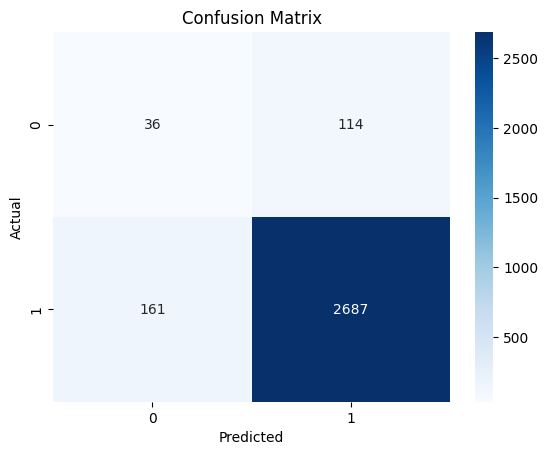

In [226]:
y_pred_cart = cart_model.predict(X_test)
evaluate_model(y_test, y_pred_cart)


### С45

Accuracy: 0.9119
Precision: 0.9578
Recall: 0.9491
F1 Score: 0.9534
AUC-ROC Score: 0.5779


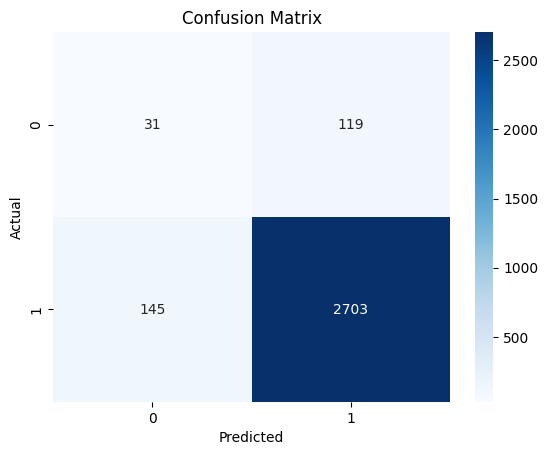

In [227]:
from sklearn.tree import DecisionTreeClassifier

c45_approx_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
c45_approx_model.fit(X_train_resampled, y_train_resampled)
y_pred_c45_approx = c45_approx_model.predict(X_test)
evaluate_model(y_test, y_pred_c45_approx)


Результати для моделі CART:


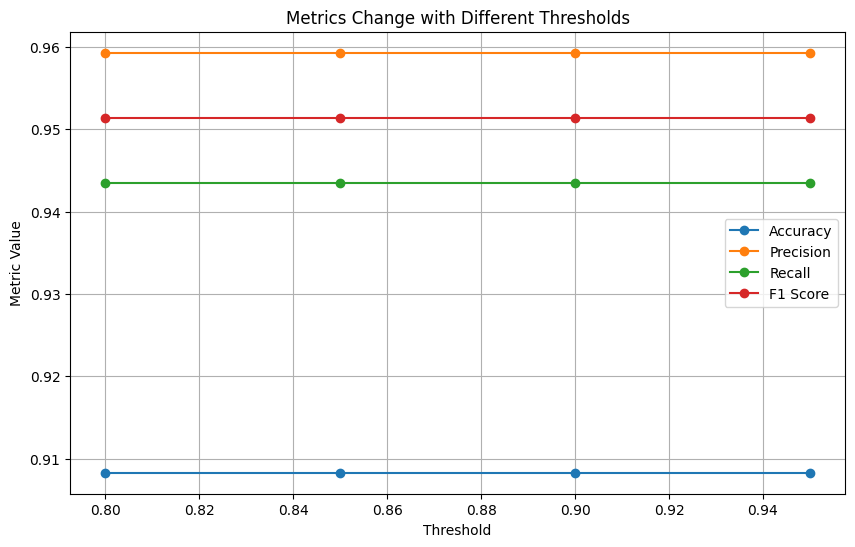

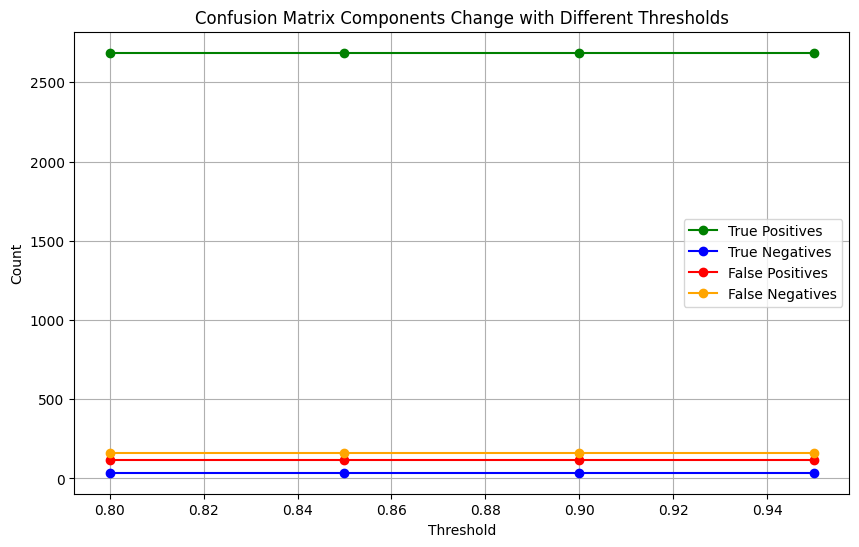

In [228]:
thresholds = [0.95, 0.90, 0.85, 0.80]
print("Результати для моделі CART:")
metrics_df_cart = predict_with_thresholds(cart_model, X_test, y_test, thresholds)


Результати для моделі C4.5:


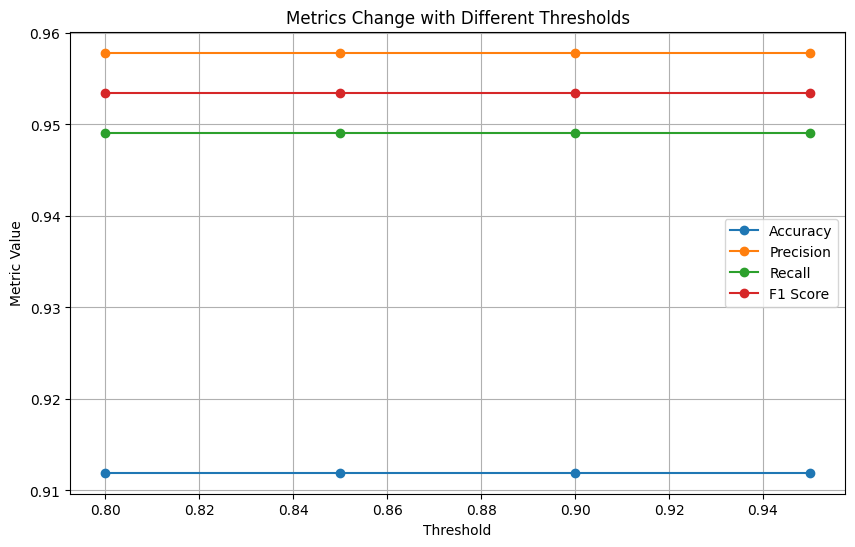

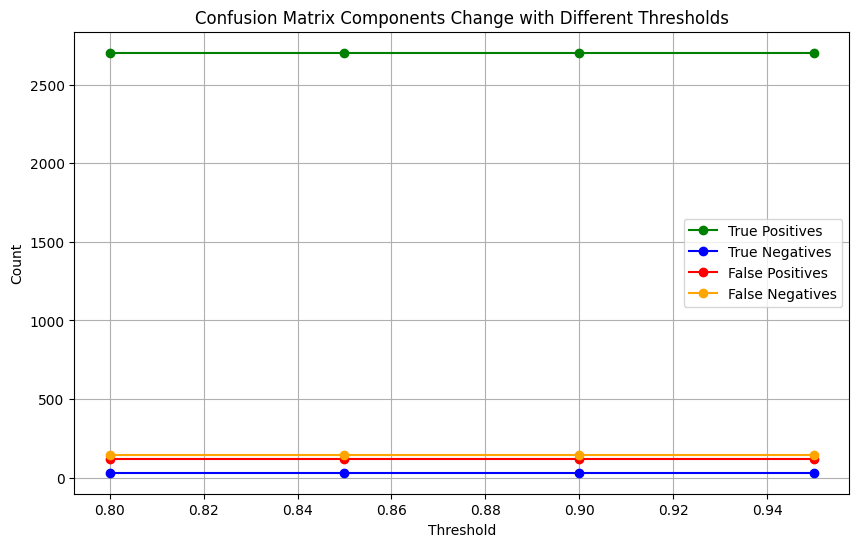

In [230]:
print("Результати для моделі C4.5:")
metrics_df_c45 = predict_with_thresholds(c45_approx_model, X_test, y_test, thresholds)


In [231]:
print("Помилки для моделі CART:")
calculate_errors(cart_model, X_train_resampled, y_train_resampled, X_test, y_test)


Помилки для моделі CART:
Похибки 1-го роду (False Positives):
Навчальна вибірка: 0, Тестова вибірка: 114
Похибки 2-го роду (False Negatives):
Навчальна вибірка: 1, Тестова вибірка: 161


In [232]:
print("Помилки для моделі C4.5:")
calculate_errors(c45_approx_model, X_train_resampled, y_train_resampled, X_test, y_test)


Помилки для моделі C4.5:
Похибки 1-го роду (False Positives):
Навчальна вибірка: 0, Тестова вибірка: 119
Похибки 2-го роду (False Negatives):
Навчальна вибірка: 1, Тестова вибірка: 145
